In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [27]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [15]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [16]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [17]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [22]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [23]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [28]:
## Explor Database

inspector = inspect(engine)
inspector.get_table_names()

## Get a list of column names and types in station

columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [30]:
## Get a list of column names and types in measurement

columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [35]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

In [118]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Starting from the most recent data point in the database.  
# Calculate the date one year from the last date in data set.
latest_date = dt.date(2017,8,23)
previous_year = latest_date - dt.timedelta(days=365)
previous_year


datetime.date(2016, 8, 23)

In [46]:
# Perform a query to retrieve the data and precipitation scores
y_to_y_precipitation = session.query(measurement.date, measurement.prcp).filter(measurement.date >= previous_year).all()



In [57]:
# Save the query results as a Pandas DataFrame and set the index to the date column
annual_precipitation_df = pd.DataFrame(y_to_y_precipitation, columns = ['Date', 'Precipitation'])
#annual_precipitation_df.set_index("Date", inplace=True)

In [58]:
# Sort the dataframe by date
annual_precipitation_df = annual_precipitation_df.sort_values(["Date"])
annual_precipitation_df 


,Date,Precipitation
0,2016-08-23,0.00
1009,2016-08-23,NaN
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15
...,...,...
1527,2017-08-22,0.00
1008,2017-08-23,0.00
360,2017-08-23,0.00
1528,2017-08-23,0.08


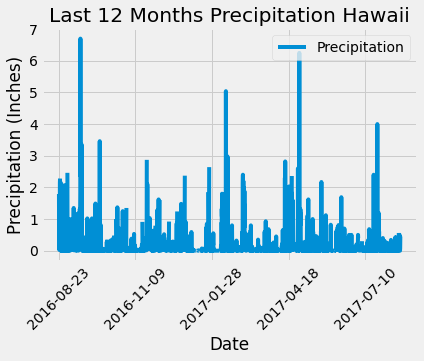

In [143]:
# Use Pandas Plotting with Matplotlib to plot the data

# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin

## Plot a line chart with the time values on the x-axis and the tumor volume values on the y-axis
annual_precipitation_df.plot('Date', 'Precipitation')
plt.xticks(rotation=45)
plt.legend(loc='upper right')

## Add labels and title to plot
plt.title("Last 12 Months Precipitation Hawaii")
plt.xlabel("Date")
plt.ylabel("Precipitation (Inches)")

## Save output of plot
plt.savefig("Output/precipitation_12_months.png")

## Display plot
plt.show()

In [54]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_precipitation = annual_precipitation_df["Precipitation"].describe()
summary_precipitation_df = pd.DataFrame(summary_precipitation)

## Print summary statistics df
summary_precipitation_df

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [88]:
## Get a list of column names and types in station

columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [80]:
# Design a query to calculate the total number stations in the dataset
station_dist_count = session.query(station.station).distinct().count()

## Print results of station_dist_count query
print(f'There are {station_dist_count} distinct stations in the dataset')

There are 9 distinct stations in the dataset


In [90]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

stations_by_activity = session.query(measurement.station,func.count(measurement.date)).\
group_by(measurement.station).\
order_by(func.count(measurement.date).desc()).all()
  
print(stations_by_activity)


[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [131]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station=session.query(measurement.station).\
group_by(measurement.station).\
order_by(func.count(measurement.date).desc()).first()



station_summary_most_active = session.query(measurement.station,func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).\
filter(measurement.station==most_active_station[0]).all()

min_temp = station_summary_most_active[0][1]
max_temp = station_summary_most_active[0][2]
avg_temp = station_summary_most_active[0][3]

## Print results of summary of most active station
print(f'{most_active_station[0]} is the most active station\nMin observerd temp: {min_temp} \nMax observerd temp: {max_temp} \nAverage observerd temp: {avg_temp}')


USC00519281 is the most active station
Min observerd temp: 54.0 
Max observerd temp: 85.0 
Average observerd temp: 71.66378066378067


In [132]:
# Using the most active station id query the last 12 months of temperature observation data for this station and plot the results as a histogram

## query for last 12 months of most active station observed temperature

y_to_y_most_active = session.query(measurement.station,measurement.date, measurement.tobs).\
filter(measurement.date >= previous_year,measurement.station==most_active_station[0]).all()

#y_to_y_most_active_tobs = session.query(measurement.tobs).\
#filter(measurement.date >= previous_year,measurement.station==most_active_station[0]).all()

#y_to_y_most_active_date = session.query(measurement.date).\
#filter(measurement.date >= previous_year,measurement.station==most_active_station[0]).all()

#y_to_y_most_active_tobs_df = pd.DataFrame(y_to_y_most_active_tobs)
#y_to_y_most_active_tobs_df = pd.DataFrame(y_to_y_most_active_tobs)
y_to_y_most_active_df = pd.DataFrame(y_to_y_most_active)
y_to_y_most_active_df

,0,1,2
0,USC00519281,2016-08-23,77.0
1,USC00519281,2016-08-24,77.0
2,USC00519281,2016-08-25,80.0
3,USC00519281,2016-08-26,80.0
4,USC00519281,2016-08-27,75.0
...,...,...,...
347,USC00519281,2017-08-14,77.0
348,USC00519281,2017-08-15,77.0
349,USC00519281,2017-08-16,76.0
350,USC00519281,2017-08-17,76.0


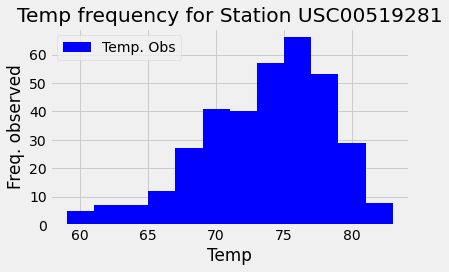

In [142]:
# the histogram of the data

y_to_y_most_active_df.plot.hist(bins=12,facecolor='b')
plt.xlabel('Temp')
plt.ylabel('Freq. observed')
plt.title('Temp frequency for Station '+ most_active_station[0])
plt.tight_layout()
plt.legend(['Temp. Obs'])
plt.grid(True)

## Save output of plot

plt.savefig("Output/frequency_active_station_histogram.png")


plt.show()

# Close session

In [144]:
# Close Session
session.close()